In [1]:
import scanpy as sc
import pandas as pd
import sys
sys.path.append("../")

## Example 2: Multi-timepoint modeling

In [2]:
import echidna as ec
ec.pl.activate_plot_settings()

As in the first example, read in your single-cell and copy number data. This time, our AnnData contains cells across multiple timepoints of treatment, "pre" and "on".

In [3]:
adata = sc.read_h5ad("data/R310_scRNA_MT.h5")
wdf = pd.read_csv("data/R310_W_MT.csv").set_index("geneName")

In [4]:
# W has two out of order timepoints.
# We will define a setting to handle this behavior explicitly and uniformly.
wdf.describe()

,R310_pre_count,R310_on2_count
count,43679.000000,43679.000000
mean,2.181906,2.325252
std,0.845191,0.868366
min,0.018235,0.018235
25%,2.000000,2.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,12.882468,12.311791


Pre-process your data if necessary. I've already run this step and saved the processed AnnData. Your pre-processing should do the following:

1. Save the raw single-cell counts in a layer
2. Cluster labels for Echidna to leverage
3. Create a timepoint label

In the `EchidnaConfig`, you can tell Echidna where to look for the necessary data. Specify your timepoint column (`timepoint_label`), your cluster labels (`clusters`), and your counts layer (`counts_layer`). Echidna will look in the column you specify in `EchidnaConfig` to know which cells were taken from which timepoint.

For multi-timepoint, we need to be careful about the ordering of our data. Below, specify the sequential order of the timepoint labels. These should be present in your `.obs[timepoint_label]` (specified in config) as well as in the columns of `wdf`, your CN counts. For example, our data is ordered "pre" (before treatment), then "on" (during treatment), then "post" (after treatment), and so on. Echidna will use this ordering whenever it needs to construct your data tensors using the original data you pass.

In [5]:
ec.tl.set_sort_order(
    adata,
    ["pre", "on", "on1", "on2", "post", "post1", "post1_pre2", "post1_on2", "post2"]
)

2024-10-19 03:47:10,606 | INFO : Added `.obs['echidna_split']`: the Echidna train/validation split.
 381 cells in validation set.
2024-10-19 03:47:10,628 | INFO : Added `.var[echidna_matched_genes]` : Labled True for genes contained in W.
2024-10-19 03:47:10,635 | INFO : Added `.var[echidna_W_R310_pre_count]` : CN entries for genes contained in W.
2024-10-19 03:47:10,635 | INFO : Added `.var[echidna_W_R310_on2_count]` : CN entries for genes contained in W.
training loss: 0.7687 | validation loss: 0.1131:   2%|▉                                                | 191/10000 [00:32<27:39,  5.91it/s]
2024-10-19 03:47:53,349 | INFO : Early stopping has been triggered.


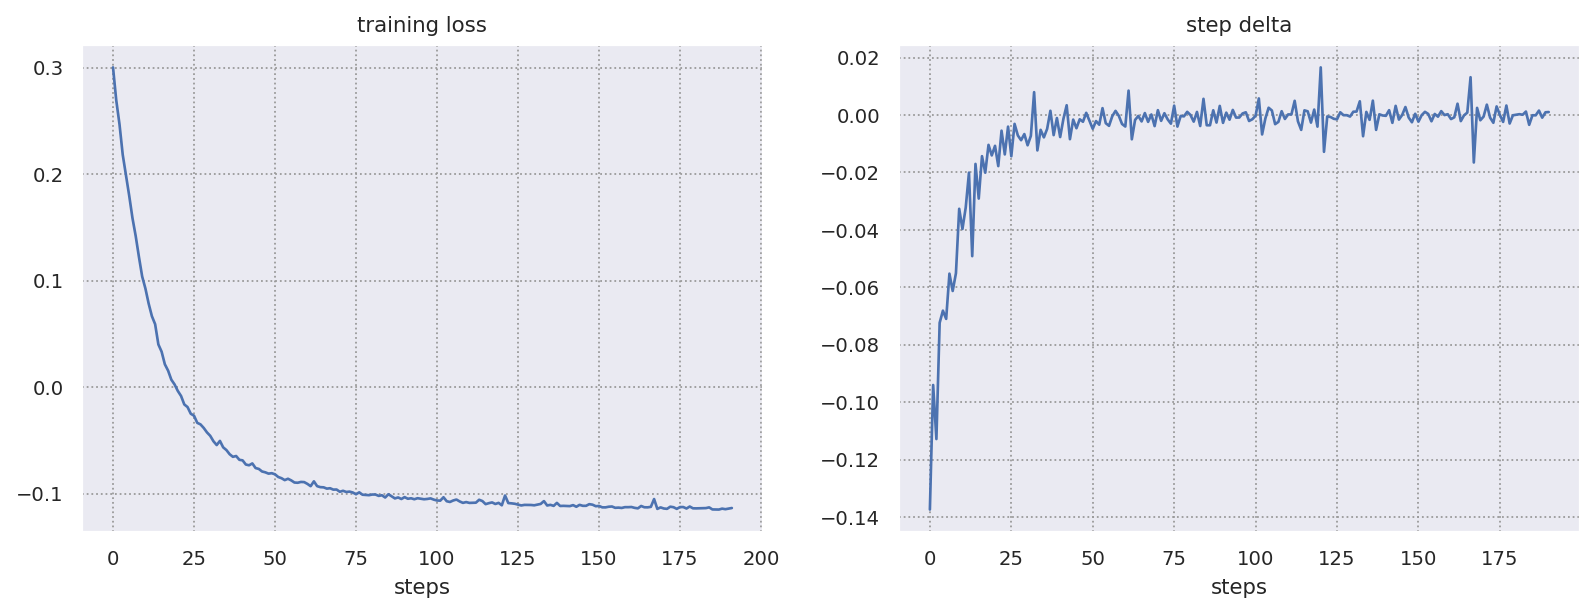

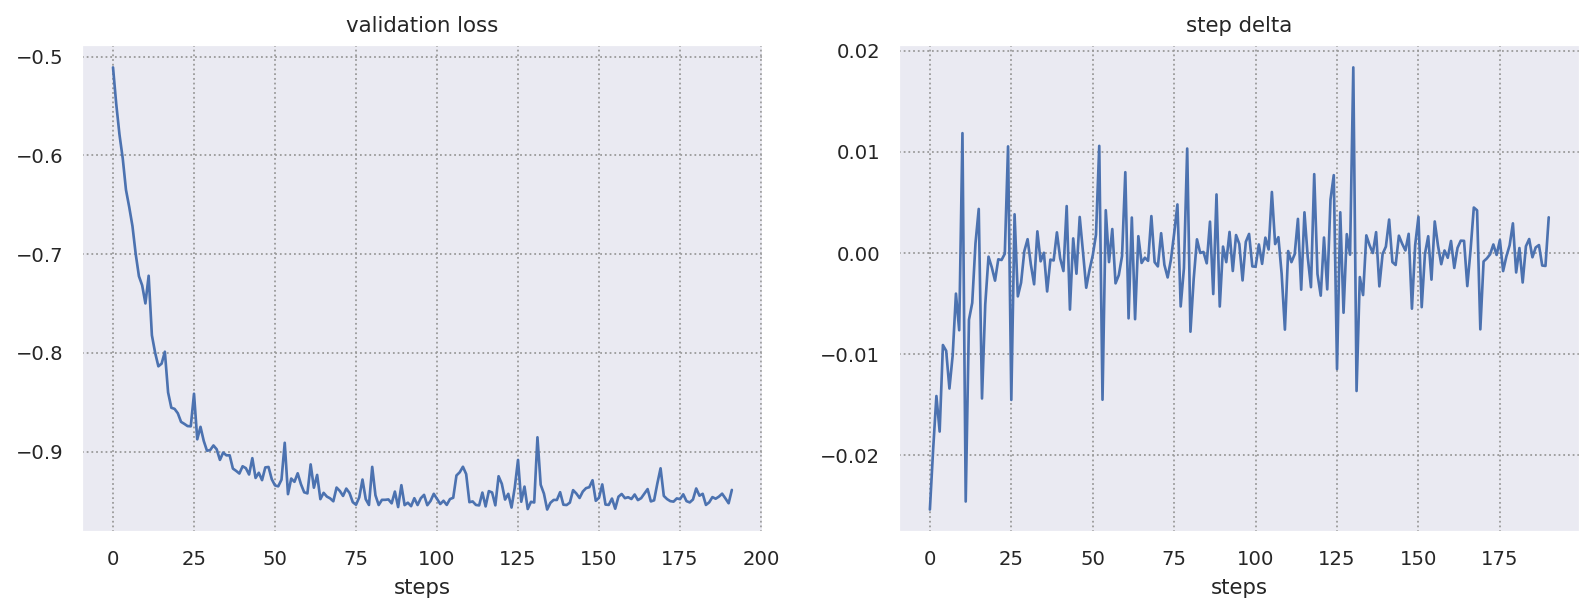

2024-10-19 03:48:14,143 | INFO : Saving echidna model with run_id 20241019-034814.


In [6]:
config = ec.tl.EchidnaConfig(
    timepoint_label = "timepoint", # `assert 'timepoint' in adata.obs.columns`
    counts_layer = "counts", # `assert 'counts' in list(adata.layers.keys())`
    clusters = "leiden", # `assert 'leiden' in adata.obs.columns`
    inverse_gamma = False, # Inverse Gamma False when we have more data
    eta_mean_init = 2., # Our genes average approximately two copies
    patience = 50, # Increase/decrease to affect early stopping
    learning_rate = .1,
)
ec.tl.echidna_train(
     adata # Single-cell AnnData
    , wdf # Copy number  pd.DataFrame, indexed with genes
    , config # Config settings
)

Again use `ec.pl.plate_model` to visualize the plate model. You may need to install graphviz on your machine and in the environment.

We can see how our hierarchy changes with more than one timepoint.

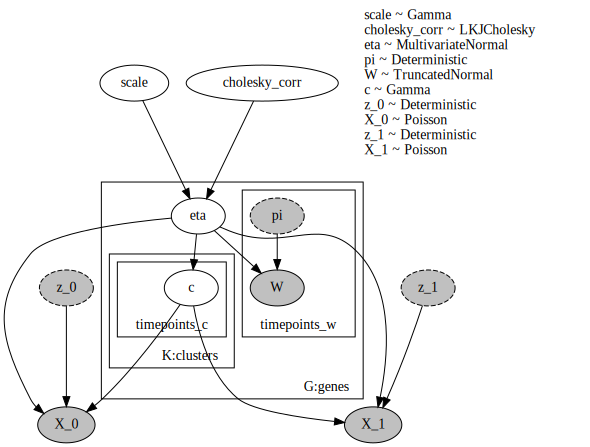

In [7]:
ec.pl.plate_model(adata)

For the sake of the example, we show how to calculate hierarchical clustering with cophenetic distances on the covariance of clusters. Select settings according to the specificities of your data.

In [8]:
ec.tl.echidna_clones(adata)

2024-10-19 03:48:15,131 | INFO : Dendrogram knee point: 8
2024-10-19 03:48:15,132 | INFO : Dendrogram threshold: 0.1409
2024-10-19 03:48:15,144 | INFO : Added `.obs['echidna_clones']`: the learned clones from eta.


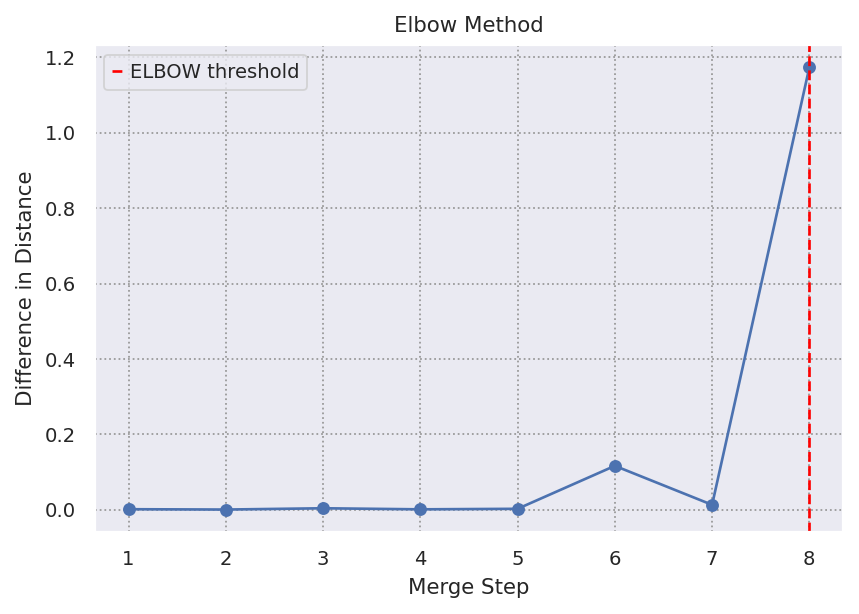

In [9]:
ec.pl.dendrogram(adata, elbow=True)

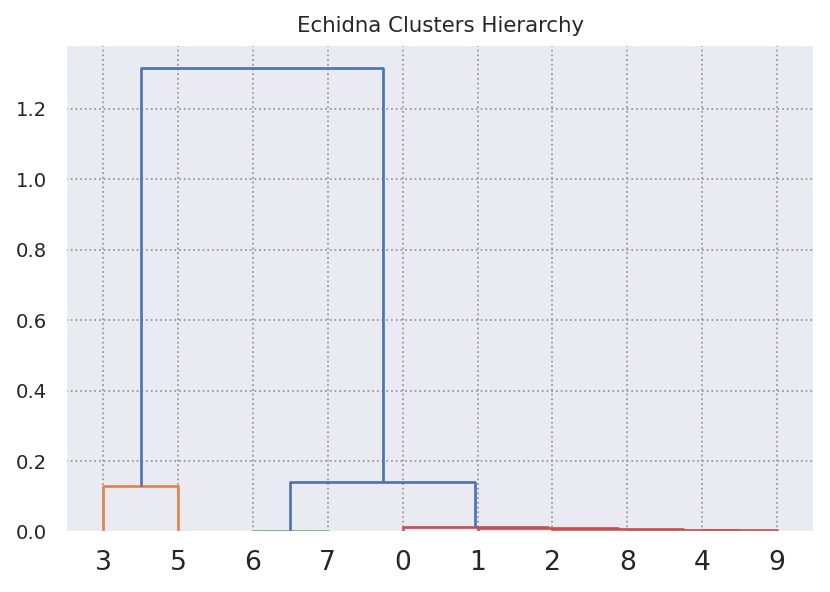

In [10]:
ec.pl.dendrogram(adata)

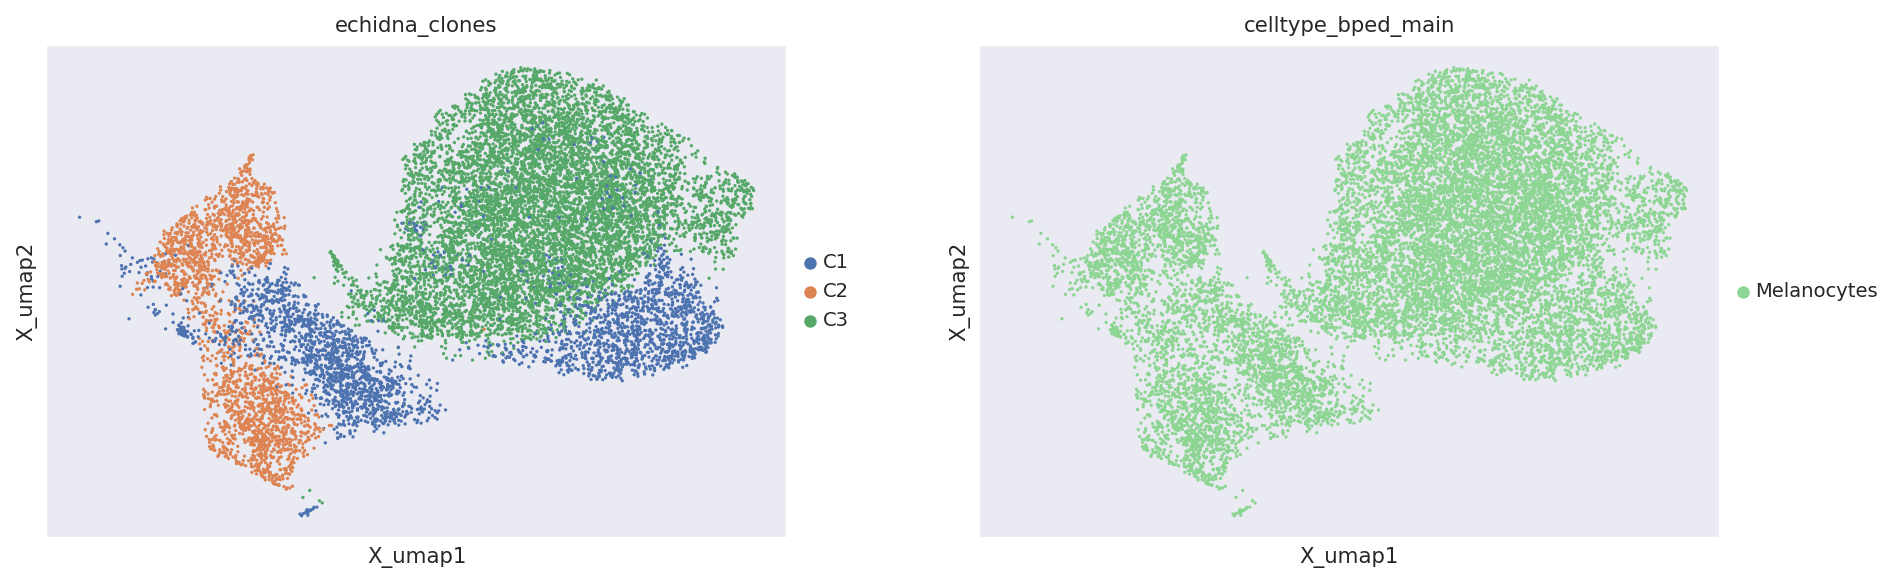

In [11]:
ec.pl.echidna(adata, ["echidna_clones", "celltype_bped_main"])

PPCs of the multi-timepoint case works the same as in the single-timepoint case. In both settings, we seek to generate data of similar distribution to our observed data.

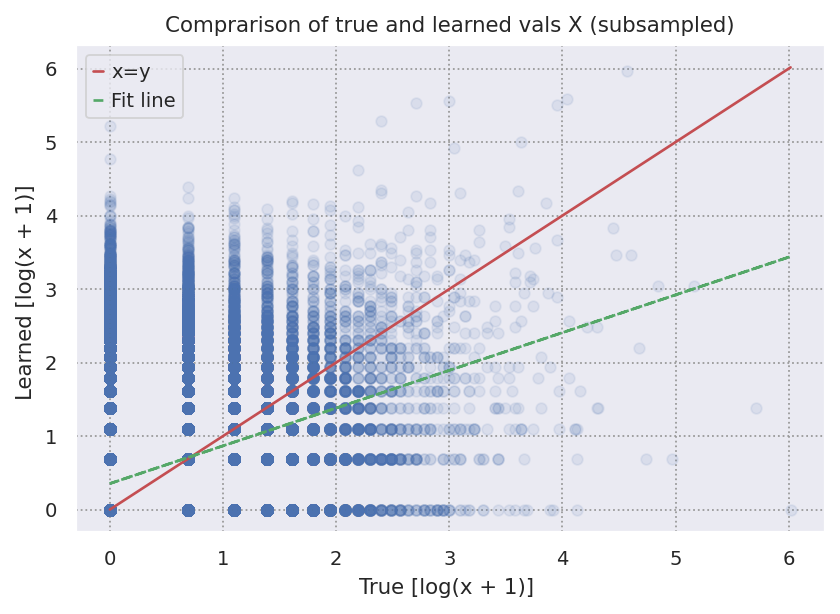

In [12]:
ec.pl.ppc(adata, "X")

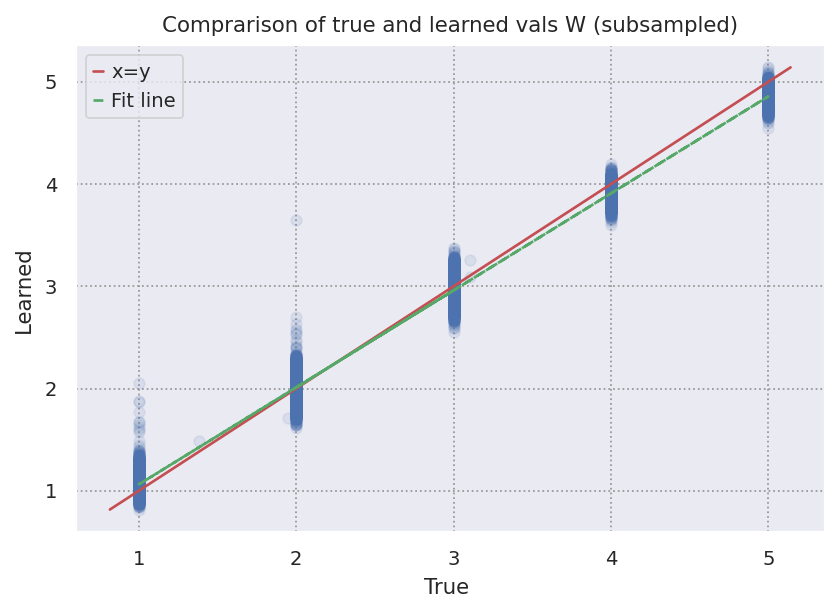

In [13]:
ec.pl.ppc(adata, "W")

training loss: 2.2903 | validation loss: 0.3869:   3%|█▏                                               | 254/10000 [00:37<24:17,  6.69it/s]
2024-10-19 03:49:35,807 | INFO : Early stopping has been triggered.


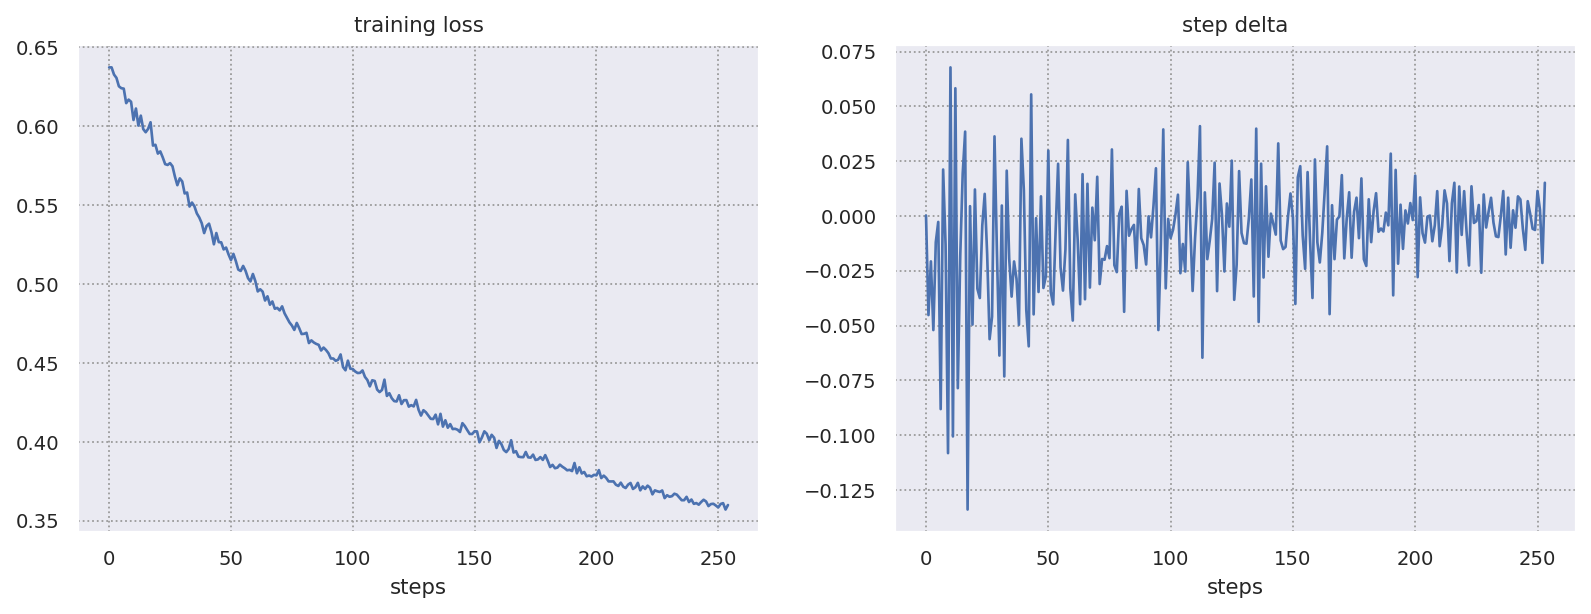

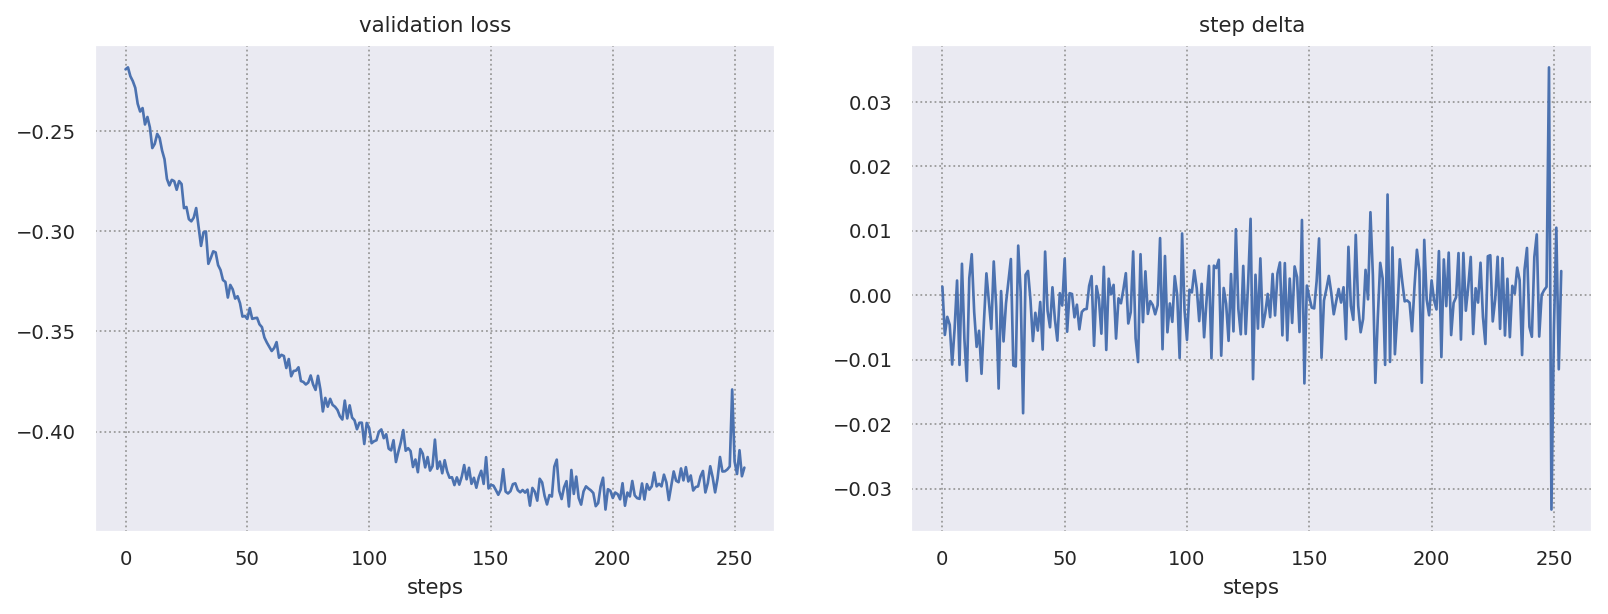

2024-10-19 03:49:55,141 | INFO : Saving echidna simulation model with run_id 20241019-034955.


In [14]:
adata.uns["echidna"]["config"]["learning_rate"] = .01
adata.uns["echidna"]["config"]["patience"] = 60
ec.tl.simulate(adata)

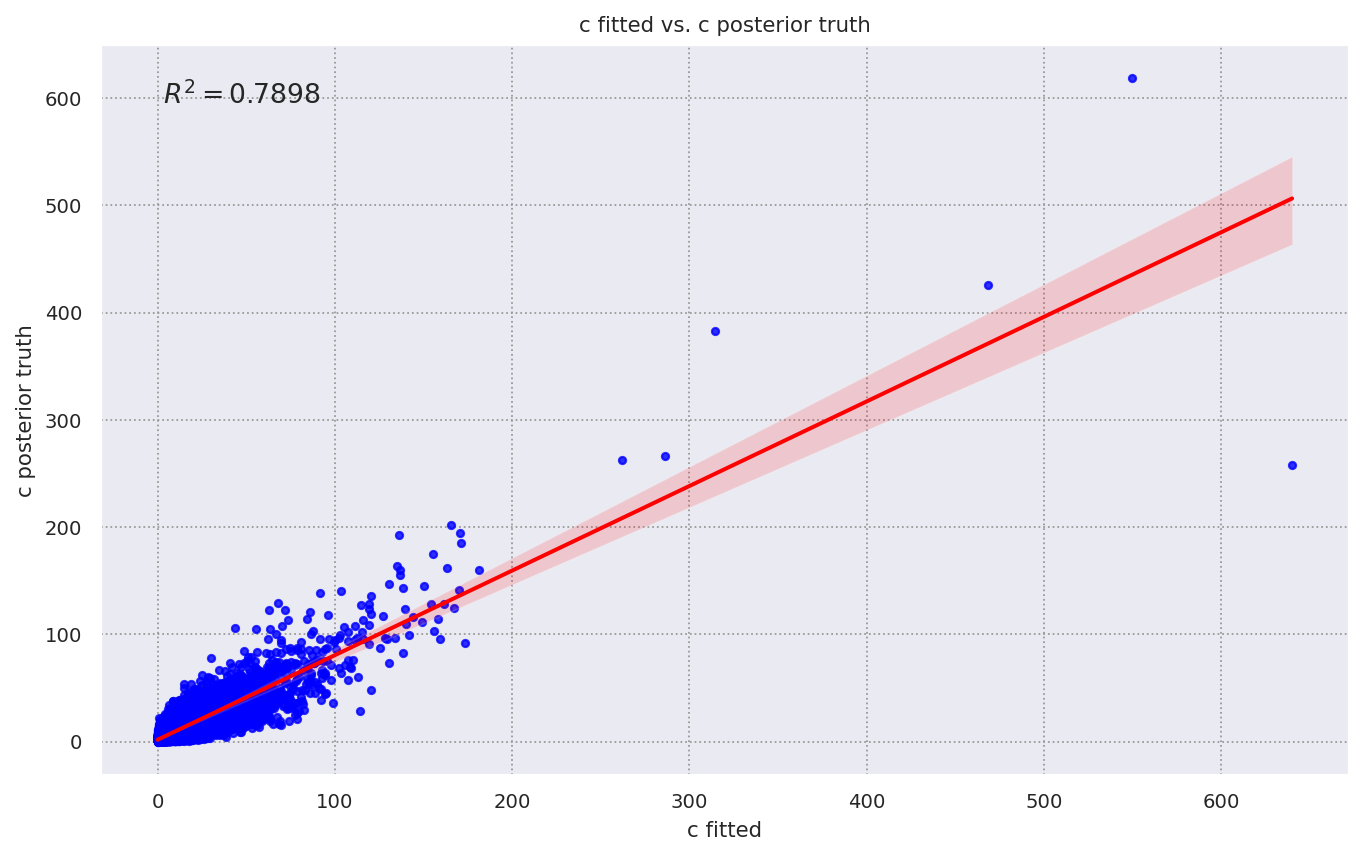

In [15]:
ec.pl.ppc(adata, "c")

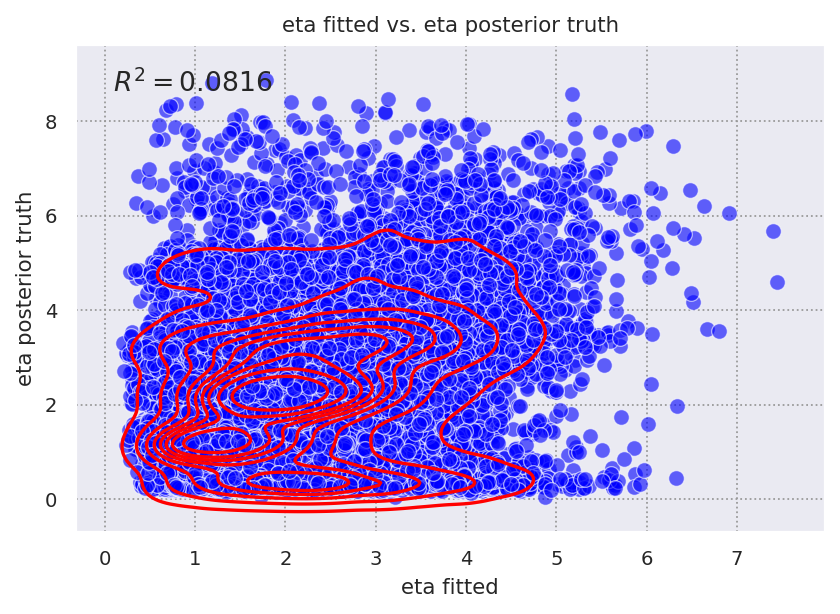

In [16]:
ec.pl.ppc(adata, "eta")

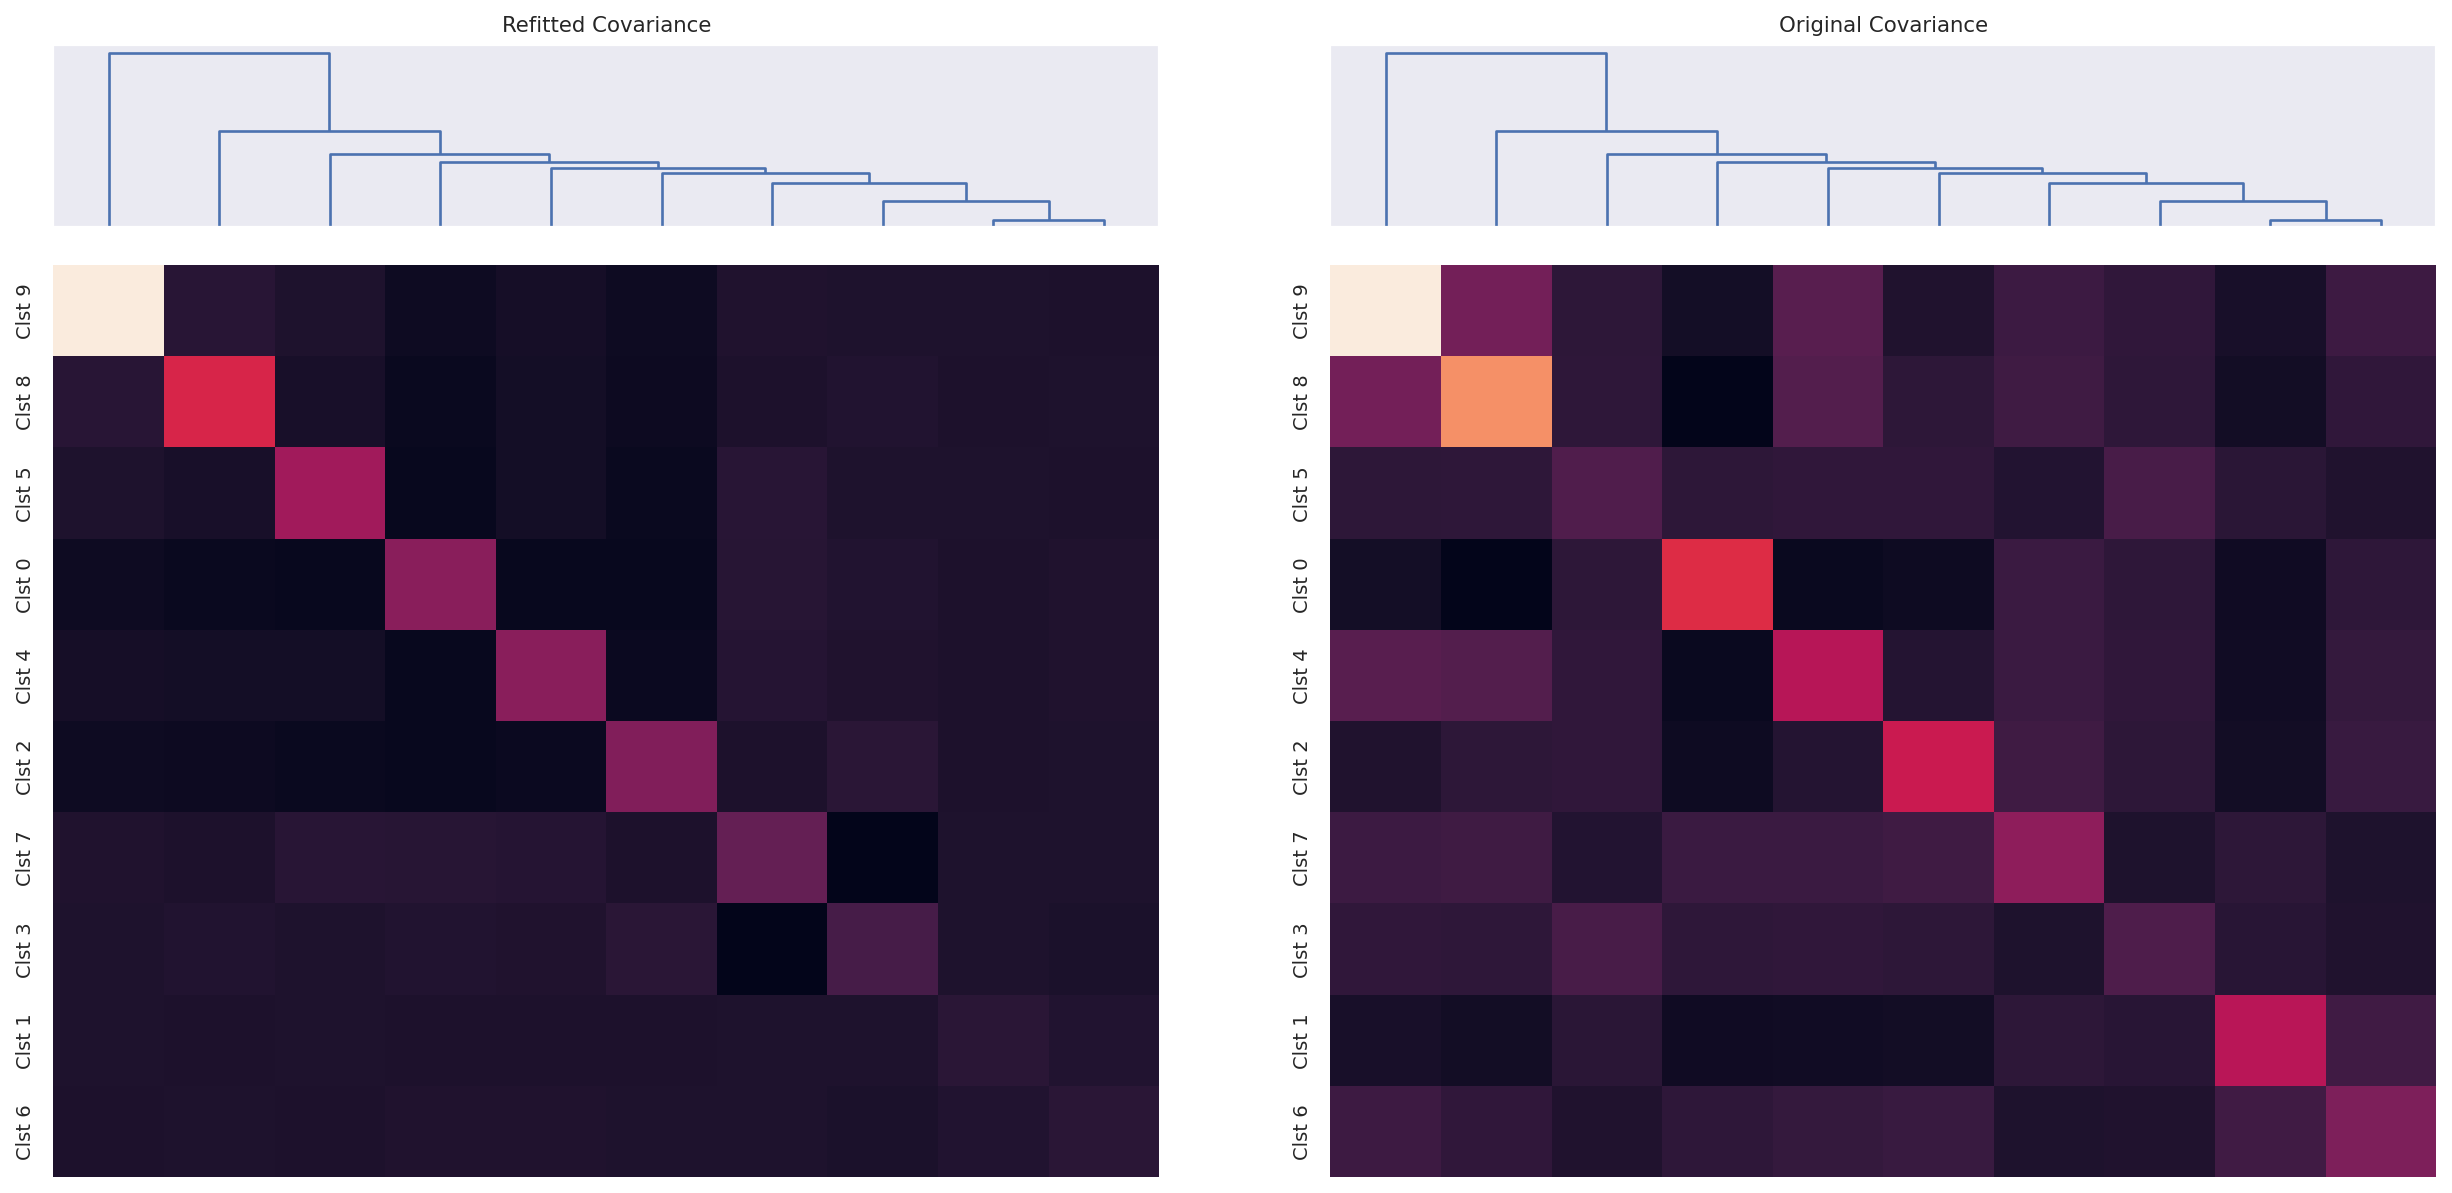

In [17]:
ec.pl.ppc(adata, "cov")

When sampling data with multi-timepoint configuration, variables with time-dimension will sample according to the timepoints in `.obs[timepoint_label]`.

In [18]:
ec.tl.sample(adata, ["X", "W"])

[tensor([[[1., 3., 1.,  ..., 2., 1., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 3.,  ..., 1., 0., 1.],
          [0., 5., 2.,  ..., 5., 1., 0.],
          [0., 0., 0.,  ..., 1., 0., 0.]],
 
         [[1., 4., 3.,  ..., 3., 9., 2.],
          [1., 0., 1.,  ..., 0., 2., 1.],
          [4., 9., 5.,  ..., 6., 9., 2.],
          ...,
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 1., 1., 0.],
          [0., 1., 0.,  ..., 1., 0., 0.]]], device='cuda:0'),
 tensor([[1.9093, 2.0407, 2.0860,  ..., 2.0521, 2.1897, 1.9321],
         [2.0744, 1.9433, 1.8988,  ..., 1.8718, 2.0896, 1.9556]],
        device='cuda:0')]

We will save this file for use in the future tutorials:

In [19]:
adata.write_h5ad("data/R310_MT_SAVE.h5ad")

If you ever need to clear space in your hard drive, run the following command to clear out the Echidna save data.

In [20]:
# ec.tl.reset_echinda_memory()